# Lab 9

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

## a)

In [2]:
mi = np.array([1, 5])
sigma = np.array([1, 2])
pi = np.array([0.3, 0.7])
n = 2000

In [3]:
np.random.seed(0)
data = np.zeros(n)
for i in range(n):
    r = np.random.rand()
    for j in range(len(pi)):
        if r < np.sum(pi[:j+1]):
            data[i] = np.random.normal(mi[j], sigma[j])
            break

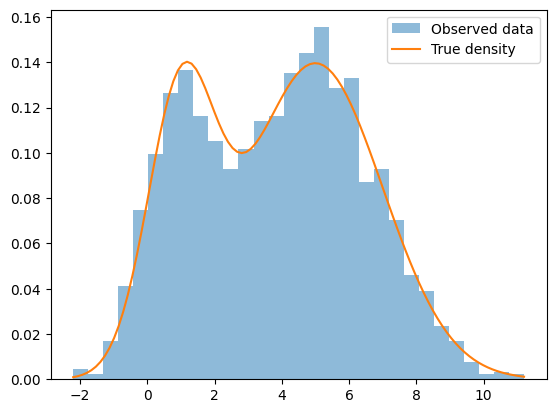

In [4]:
# draw a histogram of the data
plt.hist(data, bins=30, density=True, alpha=0.5, label="Observed data")

# plot the true density function
x = np.linspace(min(data), max(data), 100)

y = np.sum([
    pi[j] * np.exp(-0.5 * (x - mi[j])**2 / sigma[j]**2) / np.sqrt(2 * np.pi * sigma[j]**2)
    for j in range(len(pi))
], axis=0)
plt.plot(x, y, label="True density")

plt.legend()
plt.show()

# b)

$$\sum_{i=1}^n \log p(x_i, G_i | \theta) = \sum_{i=1}^n \left( (1-g_i)(\log N(\mu_0, \sigma_0^2) + \log \pi_0) + g_i(\log N(\mu_1, \sigma_1^2) + \log \pi_1) \right)$$

$$\gamma_i = \frac{\pi_0 N(\mu_0, \sigma_0^2)}{\pi_0 N(\mu_0, \sigma_0^2) + \pi_1 N(\mu_1, \sigma_1^2) }$$

In [5]:
def loglikelihood(data, G, mi, sigma, pi):
    n = len(data)
    logl = 0

    for i in range(n):
        for j in range(len(mi)):
          logl += G[i][j] * (np.log(norm.pdf(data[i], loc=mi[j], scale=np.sqrt(sigma[j])))) + np.log(pi[j])

    return logl

# c)

In [7]:
# E-step computations
def E_step(data, mi, sigma, pi):
    K = len(pi)
    n = len(data)

    gammas = np.zeros((n, K))

    for i in range(K):
        gammas[:, i] = pi[i] * norm.pdf(data, loc=mi[i], scale=np.sqrt(sigma[i]))

    summed = np.sum(gammas, axis=1)[:, None]
    return gammas / summed

# d)

In [8]:
# M-step computations
def M_step(data, G):
    n = len(data)
    K = G.shape[1]

    mi = np.zeros(K)
    sigma = np.zeros(K)
    pi = np.zeros(K)

    for j in range(K):
        summed = np.sum(G[:, j])
        mi[j] = np.sum(G[:, j] * data) / summed
        sigma[j] = np.sum(G[:, j] * (data - mi[j]) ** 2) / summed

    pi = np.mean(G, axis=0)
    return mi, sigma, pi

# e)

In [9]:
# EM algorithm
def EM_algorithm(data, mi, sigma, pi, max_iter=100, tol=1e-6):
    logl = float("-Inf")
    for i in range(max_iter):
        G = E_step(data, mi, sigma, pi)
        mi, sigma, pi = M_step(data, G)

        new_logl = loglikelihood(data, G, mi, sigma, pi)
        if np.abs(new_logl - logl) < tol:
            break
        logl = new_logl

    return mi, sigma, pi, logl

In [10]:
mi_start = np.array([-1, 1])
sigma_start = np.array([1, 1])
pi_start = np.array([0.5, 0.5])

In [11]:
theta_estimated = EM_algorithm(data, mi_start, sigma_start, pi_start)
mi_estimated, sigma_estimated, pi_estimated, logl = theta_estimated

In [12]:
df = pd.DataFrame({
    "true": np.concatenate([mi, sigma, pi]),
    "estimated": np.concatenate([mi_estimated, sigma_estimated, pi_estimated]),
    "abs_diff": np.abs(np.concatenate([mi, sigma, pi]) - np.concatenate([mi_estimated, sigma_estimated, pi_estimated]))
}, index=[f"mi_{i}" for i in range(len(mi))] + [f"sigma_{i}" for i in range(len(sigma))] + [f"pi_{i}" for i in range(len(pi))])
df

,true,estimated,abs_diff
mi_0,1.0,0.840903,0.159097
mi_1,5.0,4.943944,0.056056
sigma_0,1.0,0.906299,0.093701
sigma_1,2.0,3.913536,1.913536
pi_0,0.3,0.278709,0.021291
pi_1,0.7,0.721291,0.021291


# f)

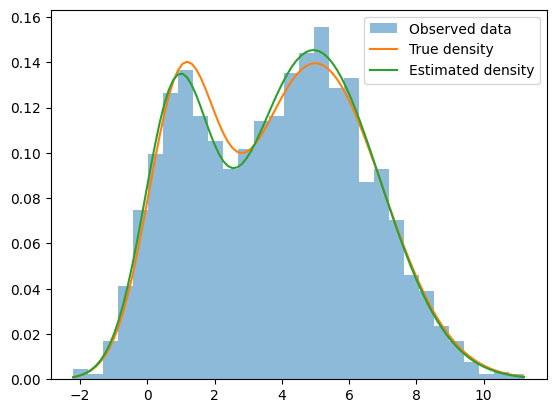

In [13]:
plt.hist(data, bins=30, density=True, alpha=0.5, label="Observed data")
plt.plot(x, y, label="True density")

y_estimated = np.sum([
    pi_estimated[j] * norm.pdf(x, loc=mi_estimated[j], scale=np.sqrt(sigma_estimated[j]))
    for j in range(len(pi_estimated))
], axis=0)

plt.plot(x, y_estimated, label="Estimated density")
plt.legend()
plt.show()

# g)

In [14]:
# repeat for a gaussian mixture model with 3 components
mi = np.array([-2, 0, 2])
sigma = np.array([0.5, 0.5, 0.5])
pi = np.array([0.2, 0.7, 0.1])
n = 2000

In [15]:
# generate data
np.random.seed(0)
data = np.zeros(n)
for i in range(n):
    r = np.random.rand()
    for j in range(len(pi)):
        if r < np.sum(pi[:j+1]):
            data[i] = np.random.normal(mi[j], sigma[j])
            break

In [16]:
# estimate
mi_start = np.array([-1, 0, 1])
sigma_start = np.array([1, 1, 1])
pi_start = np.array([1/3, 1/3, 1/3])

theta_estimated = EM_algorithm(data, mi_start, sigma_start, pi_start)
mi_estimated, sigma_estimated, pi_estimated, logl = theta_estimated

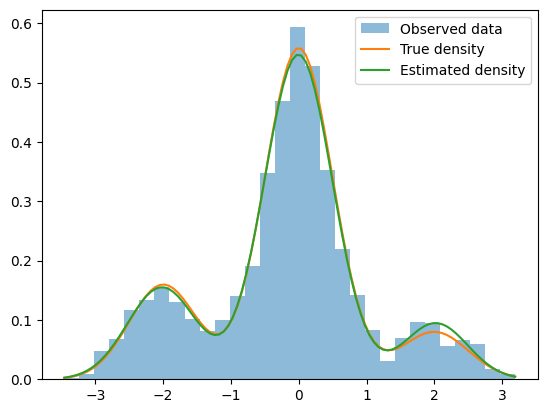

In [18]:
# plot
plt.hist(data, bins=30, density=True, alpha=0.5, label="Observed data")
x = np.linspace(min(data), max(data), 100)
y = np.sum([
    pi[j] * np.exp(-0.5 * (x - mi[j])**2 / sigma[j]**2) / np.sqrt(2 * np.pi * sigma[j]**2)
    for j in range(len(pi))
], axis=0)
plt.plot(x, y, label="True density")

y_estimated = np.sum([
    pi_estimated[j] * norm.pdf(x, loc=mi_estimated[j], scale=np.sqrt(sigma_estimated[j]))
    for j in range(len(pi_estimated))
], axis=0)
plt.plot(x, y_estimated, label="Estimated density")

plt.legend()
plt.show()

In [19]:
# repeat for a gaussian mixture model with 5 components
mi = np.array([-2, -1, 2, 4, 8])
sigma = np.array([0.5, 0.5, 1, 1, 3])
pi = np.array([0.1, 0.2, 0.3, 0.2, 0.2])
n = 2000

In [20]:
# generate data
np.random.seed(0)
data = np.zeros(n)
for i in range(n):
    r = np.random.rand()
    for j in range(len(pi)):
        if r < np.sum(pi[:j+1]):
            data[i] = np.random.normal(mi[j], sigma[j])
            break

In [21]:
# estimate
mi_start = np.array([-2, -1, 0, 1, 2])
sigma_start = np.array([1, 1, 1, 1, 1])
pi_start = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

theta_estimated = EM_algorithm(data, mi_start, sigma_start, pi_start)
mi_estimated, sigma_estimated, pi_estimated, logl = theta_estimated

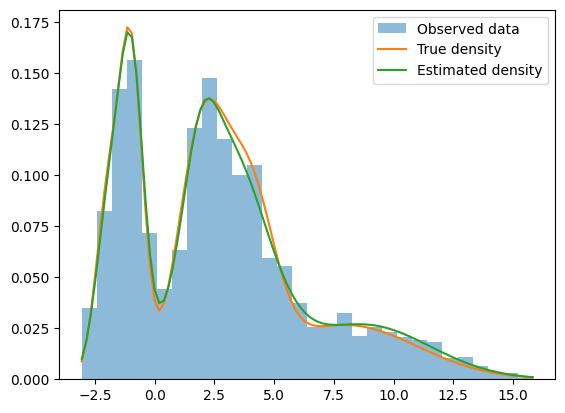

In [22]:
# plot
plt.hist(data, bins=30, density=True, alpha=0.5, label="Observed data")
x = np.linspace(min(data), max(data), 100)
y = np.sum([
    pi[j] * np.exp(-0.5 * (x - mi[j])**2 / sigma[j]**2) / np.sqrt(2 * np.pi * sigma[j]**2)
    for j in range(len(pi))
], axis=0)
plt.plot(x, y, label="True density")

y_estimated = np.sum([
    pi_estimated[j] * norm.pdf(x, loc=mi_estimated[j], scale=np.sqrt(sigma_estimated[j]))
    for j in range(len(pi_estimated))
], axis=0)
plt.plot(x, y_estimated, label="Estimated density")

plt.legend()
plt.show()